In [3]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

experiment_dir = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments")
training_data_cache_dir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/training_data_cache")
dev_dir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks")
data_dir = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/organized_experiment_results_excel")


# Macrophage experiments
macrophage_experiment_dict = {
    "Initial Settings": experiment_dir / "Macrophage_base_settings" / "chr19" / "model_training_006",
    "model_d_128_ff_512": experiment_dir / "Macrophage_model_d_128_ff_512" / "chr19" / "model_training_001",
    "small_batch_size": experiment_dir / "Macrophage_small_batch_size" / "chr19" / "model_training_002",
    "loose_1_pct_filtering": experiment_dir / "Macrophage_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "strict_10_pct_filtering": experiment_dir / "Macrophage_strict_10_pct_filtering" / "chr19" / "model_training_001",
    "40k_distance_scale_factor": experiment_dir / "Macrophage_40k_distance_scale_factor" / "chr19" / "model_training_001",
    "10k_distance_scale_factor": experiment_dir / "Macrophage_10k_distance_scale_factor" / "chr19" / "model_training_002",
    "150k_max_peak_dist": experiment_dir / "Macrophage_150k_max_peak_dist" / "chr19" / "model_training_001",
    "50k_max_peak_dist": experiment_dir / "Macrophage_50k_max_peak_dist" / "chr19" / "model_training_001",
    "slow_decay_long_range_two_hop": experiment_dir / "Macrophage_slow_decay_long_range_two_hop" / "chr19" / "model_training_001",
    "slow_decay_long_range": experiment_dir / "Macrophage_slow_decay_long_range" / "chr19" / "model_training_001",
    "zero_hops": experiment_dir / "Macrophage_zero_hops" / "chr19" / "model_training_001",
    "two_hops": experiment_dir / "Macrophage_two_hops" / "chr19" / "model_training_001",
    "loose_1_pct_filter_50_min_per_cell": experiment_dir / "Macrophage_loose_1_pct_filter_50_min_per_cell" / "chr19" / "model_training_001",
    "small_model_loose_1_pct_filtering": experiment_dir / "Macrophage_small_model_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "two_hops_small_batch": experiment_dir / "Macrophage_two_hops_small_batch" / "chr19" / "model_training_001",
    "two_hops_150k_max_peak_dist": experiment_dir / "Macrophage_two_hops_150k_max_peak_dist" / "chr19" / "model_training_001",
    "two_hops_slow_decay_long_range": experiment_dir / "Macrophage_two_hops_slow_decay_long_range" / "chr19" / "model_training_001",
    "two_hops_slow_decay_long_range_small_batch": experiment_dir / "Macrophage_two_hops_slow_decay_long_range_small_batch" / "chr19" / "model_training_001",
    "three_hops_small_batch": experiment_dir / "Macrophage_three_hops_small_batch" / "chr19" / "model_training_001",
    "two_hops_50k_max_peak_dist": experiment_dir / "Macrophage_two_hops_50k_max_peak_dist" / "chr19" / "model_training_001",
    "two_hops_10k_distance_scale_factor": experiment_dir / "Macrophage_two_hops_10k_distance_scale_factor" / "chr19" / "model_training_001",
    "two_hops_40k_distance_scale_factor": experiment_dir / "Macrophage_two_hops_40k_distance_scale_factor" / "chr19" / "model_training_001",
    "two_hops_loose_1_pct_filtering": experiment_dir / "Macrophage_two_hops_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "two_hops_moderate_5_pct_filtering_small_batch": experiment_dir / "Macrophage_two_hops_moderate_5_pct_filtering_small_batch" / "chr19" / "model_training_001",
    "small_model_two_hops_long_range_small_batch": experiment_dir / "Macrophage_small_model_two_hops_long_range_small_batch" / "chr19" / "model_training_002",
    "best_filter_long_range_2_hop_small" : experiment_dir / "Macrophage_best_filter_long_range_2_hop_small" / "chr19" / "model_training_001",
    "best_filter_long_range_3_hop_small": experiment_dir / "Macrophage_best_filter_long_range_3_hop_small" / "chr19" / "model_training_001",
    "best_filter_long_range_2_hop_small_max_bias": experiment_dir / "Macrophage_best_filter_long_range_2_hop_small_max_bias" / "chr19" / "model_training_001",
    "best_filter_long_range_2_hop_small_500bp_window": experiment_dir / "Macrophage_best_filter_long_range_2_hop_small_500bp_window" / "chr19" / "model_training_001",
    "best_filter_long_range_2_hop_small_1500bp_window": experiment_dir / "Macrophage_best_filter_long_range_2_hop_small_1500bp_window" / "chr19" / "model_training_001",
    "best_filter_long_range_2_hop_small_fewer_neighbors": experiment_dir / "Macrophage_best_filter_long_range_2_hop_small_fewer_neighbors" / "chr19" / "model_training_001",
    "best_filter_long_range_2_hop_tiny": experiment_dir / "Macrophage_best_filter_long_range_2_hop_tiny" / "chr19" / "model_training_001"

}

macrophage_experiment_training_data_dict = {
    "Initial Settings": training_data_cache_dir / "Macrophage_base_settings",
    "model_d_128_ff_512": training_data_cache_dir / "Macrophage_model_d_128_ff_512",
    "small_batch_size": training_data_cache_dir / "Macrophage_small_batch_size",
    "loose_1_pct_filtering": training_data_cache_dir / "Macrophage_loose_1_pct_filtering",
    "strict_10_pct_filtering": training_data_cache_dir / "Macrophage_strict_10_pct_filtering",
    "40k_distance_scale_factor": training_data_cache_dir / "Macrophage_40k_distance_scale_factor",
    "10k_distance_scale_factor": training_data_cache_dir / "Macrophage_10k_distance_scale_factor",
    "150k_max_peak_dist": training_data_cache_dir / "Macrophage_150k_max_peak_dist",
    "50k_max_peak_dist": training_data_cache_dir / "Macrophage_50k_max_peak_dist",
    "slow_decay_long_range_two_hop": training_data_cache_dir / "Macrophage_slow_decay_long_range_two_hop",
    "slow_decay_long_range": training_data_cache_dir / "Macrophage_slow_decay_long_range",
    "zero_hops": training_data_cache_dir / "Macrophage_zero_hops",
    "two_hops": training_data_cache_dir / "Macrophage_two_hops",
    "loose_1_pct_filter_50_min_per_cell": training_data_cache_dir / "Macrophage_loose_1_pct_filter_50_min_per_cell",
    "small_model_loose_1_pct_filtering": training_data_cache_dir / "Macrophage_small_model_loose_1_pct_filtering",
    "two_hops_small_batch": training_data_cache_dir / "Macrophage_two_hops_small_batch",
    "two_hops_150k_max_peak_dist": training_data_cache_dir / "Macrophage_two_hops_150k_max_peak_dist",
    "two_hops_slow_decay_long_range": training_data_cache_dir / "Macrophage_two_hops_slow_decay_long_range",
    "slow_decay_long_range_small_batch": training_data_cache_dir / "Macrophage_slow_decay_long_range_small_batch",
    "two_hops_slow_decay_long_range_small_batch": training_data_cache_dir / "Macrophage_two_hops_slow_decay_long_range_small_batch",
    "three_hops_small_batch": training_data_cache_dir / "Macrophage_three_hops_small_batch",
    "two_hops_50k_max_peak_dist": training_data_cache_dir / "Macrophage_two_hops_50k_max_peak_dist",
    "two_hops_10k_distance_scale_factor": training_data_cache_dir / "Macrophage_two_hops_10k_distance_scale_factor",
    "two_hops_40k_distance_scale_factor": training_data_cache_dir / "Macrophage_two_hops_40k_distance_scale_factor",
    "two_hops_loose_1_pct_filtering": training_data_cache_dir / "Macrophage_two_hops_loose_1_pct_filtering",
    "two_hops_moderate_5_pct_filtering_small_batch": training_data_cache_dir / "Macrophage_two_hops_moderate_5_pct_filtering_small_batch",
    "small_model_two_hops_long_range_small_batch": training_data_cache_dir / "Macrophage_small_model_two_hops_long_range_small_batch",
    "best_filter_long_range_2_hop_small": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_small",
    "best_filter_long_range_3_hop_small": training_data_cache_dir / "Macrophage_best_filter_long_range_3_hop_small",
    "best_filter_long_range_2_hop_small_max_bias": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_small_max_bias",
    "best_filter_long_range_2_hop_small_500bp_window": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_small_500bp_window",
    "best_filter_long_range_2_hop_small_1500bp_window": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_small_1500bp_window",
    "best_filter_long_range_2_hop_small_fewer_neighbors": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_small_fewer_neighbors",
    "best_filter_long_range_2_hop_tiny": training_data_cache_dir / "Macrophage_best_filter_long_range_2_hop_tiny",

}

mesc_experiment_dict = {
    "Initial Settings": experiment_dir / "mESC_no_scale_linear" / "model_training_192_10k_metacells",

    "large_neighborhood_count_filter": experiment_dir / "mESC_large_neighborhood_count_filter" / "chr19" / "model_training_001",
    "large_neighborhood": experiment_dir / "mESC_large_neighborhood" / "chr19" / "model_training_001",
    "small_neighborhood": experiment_dir / "mESC_small_neighborhood" / "chr19" / "model_training_001",
    "small_neighborhood_high_self_weight": experiment_dir / "mESC_small_neighborhood_high_self_weight" / "chr19" / "model_training_001",

    "slower_dist_decay": experiment_dir / "mESC_slower_dist_decay" / "chr19" / "model_training_001",
    "max_dist_bias": experiment_dir / "mESC_max_dist_bias" / "chr19" / "model_training_002",
    "slow_decay_max_dist": experiment_dir / "mESC_slow_decay_max_dist" / "chr19" / "model_training_001",

    "filter_lowest_ten_pct": experiment_dir / "mESC_filter_lowest_ten_pct" / "chr19" / "model_training_003",
    "lower_peak_threshold": experiment_dir / "mESC_lower_peak_threshold" / "chr19" / "model_training_001",
    "no_filter_to_nearest_gene": experiment_dir / "mESC_no_filter_to_nearest_gene" / "chr19" / "model_training_003",

    "smaller_window_size": experiment_dir / "mESC_smaller_window_size" / "chr19" / "model_training_004",
    "larger_window_size": experiment_dir / "mESC_larger_window_size" / "chr19" / "model_training_002",

    "lower_max_peak_dist": experiment_dir / "mESC_lower_max_peak_dist" / "chr19" / "model_training_002",
    "higher_max_peak_dist": experiment_dir / "mESC_higher_max_peak_dist" / "chr19" / "model_training_002",

    "test_new_pipeline": experiment_dir / "mESC_test_new_pipeline" / "chr19" / "model_training_002",

    "slow_decay_filter_ten_pct": experiment_dir / "mESC_slow_decay_filter_ten_pct" / "chr19" / "model_training_001",
    "fast_decay_large_window": experiment_dir / "mESC_fast_decay_large_window" / "chr19" / "model_training_001",
    "slow_decay_small_window": experiment_dir / "mESC_slow_decay_small_window" / "chr19" / "model_training_001",

    "fewer_pca_components": experiment_dir / "mESC_fewer_pca_components" / "chr19" / "model_training_001",
    "more_pca_components": experiment_dir / "mESC_more_pca_components" / "chr19" / "model_training_001",

    "one_hop_diffusion": experiment_dir / "mESC_one_hop_diffusion" / "chr19" / "model_training_001",
    "two_hop_diffusion": experiment_dir / "mESC_two_hop_diffusion" / "chr19" / "model_training_001",
    "one_hop_large_neighborhood": experiment_dir / "mESC_one_hop_large_neighborhood" / "chr19" / "model_training_001",

    "strict_genes_lenient_peaks": experiment_dir / "mESC_strict_genes_lenient_peaks" / "chr19" / "model_training_001",
    "lenient_genes_strict_peaks": experiment_dir / "mESC_lenient_genes_strict_peaks" / "chr19" / "model_training_001",
    "strict_filter_twenty_pct": experiment_dir / "mESC_strict_filter_twenty_pct" / "chr19" / "model_training_001",

    "promoter_2kb": experiment_dir / "mESC_promoter_2kb" / "chr19" / "model_training_001",
    "promoter_5kb": experiment_dir / "mESC_promoter_5kb" / "chr19" / "model_training_001",

    "very_short_range": experiment_dir / "mESC_very_short_range" / "chr19" / "model_training_001",
    "long_range_enhancers": experiment_dir / "mESC_long_range_enhancers" / "chr19" / "model_training_001",
    
    "slow_decay_long_range_two_hop": experiment_dir / "mESC_slow_decay_long_range_two_hop" / "chr19" / "model_training_001",
    "slow_decay_long_range_zero_hops": experiment_dir / "mESC_slow_decay_long_range_zero_hops" / "chr19" / "model_training_001",
    
    "promoter_only_2kb_two_hop": experiment_dir / "mESC_promoter_only_2kb_two_hop" / "chr19" / "model_training_001",
    "promoter_only_5kb_two_hop": experiment_dir / "mESC_promoter_only_5kb_two_hop" / "chr19" / "model_training_001",
    "promoter_only_10kb_two_hop": experiment_dir / "mESC_promoter_only_10kb_two_hop" / "chr19" / "model_training_001",
    
    "decay_30k_long_range_two_hop": experiment_dir / "mESC_decay_30k_long_range_two_hop" / "chr19" / "model_training_001",
    "decay_50k_long_range_two_hop": experiment_dir / "mESC_decay_50k_long_range_two_hop" / "chr19" / "model_training_001",
    "decay_75k_long_range_two_hop": experiment_dir / "mESC_decay_75k_long_range_two_hop" / "chr19" / "model_training_001",
}

mesc_experiment_training_data_dict = {
    "Initial Settings": training_data_cache_dir / "mESC_no_scale_linear",

    "large_neighborhood_count_filter": training_data_cache_dir / "mESC_large_neighborhood_count_filter",
    "large_neighborhood": training_data_cache_dir / "mESC_large_neighborhood",
    "small_neighborhood": training_data_cache_dir / "mESC_small_neighborhood",
    "small_neighborhood_high_self_weight": training_data_cache_dir / "mESC_small_neighborhood_high_self_weight",

    "slower_dist_decay": training_data_cache_dir / "mESC_slower_dist_decay",
    "max_dist_bias": training_data_cache_dir / "mESC_max_dist_bias",
    "slow_decay_max_dist": training_data_cache_dir / "mESC_slow_decay_max_dist",

    "filter_lowest_ten_pct": training_data_cache_dir / "mESC_filter_lowest_ten_pct",
    "lower_peak_threshold": training_data_cache_dir / "mESC_lower_peak_threshold",
    "no_filter_to_nearest_gene": training_data_cache_dir / "mESC_no_filter_to_nearest_gene",

    "smaller_window_size": training_data_cache_dir / "mESC_smaller_window_size",
    "larger_window_size": training_data_cache_dir / "mESC_larger_window_size",

    "lower_max_peak_dist": training_data_cache_dir / "mESC_lower_max_peak_dist",
    "higher_max_peak_dist": training_data_cache_dir / "mESC_higher_max_peak_dist",

    "test_new_pipeline": training_data_cache_dir / "mESC_test_new_pipeline",

    "slow_decay_filter_ten_pct": training_data_cache_dir / "mESC_slow_decay_filter_ten_pct",
    "fast_decay_large_window": training_data_cache_dir / "mESC_fast_decay_large_window",
    "slow_decay_small_window": training_data_cache_dir / "mESC_slow_decay_small_window",

    "fewer_pca_components": training_data_cache_dir / "mESC_fewer_pca_components",
    "more_pca_components": training_data_cache_dir / "mESC_more_pca_components",

    "one_hop_diffusion": training_data_cache_dir / "mESC_one_hop_diffusion",
    "two_hop_diffusion": training_data_cache_dir / "mESC_two_hop_diffusion",
    "one_hop_large_neighborhood": training_data_cache_dir / "mESC_one_hop_large_neighborhood",

    "strict_genes_lenient_peaks": training_data_cache_dir / "mESC_strict_genes_lenient_peaks",
    "lenient_genes_strict_peaks": training_data_cache_dir / "mESC_lenient_genes_strict_peaks",
    "strict_filter_twenty_pct": training_data_cache_dir / "mESC_strict_filter_twenty_pct",

    "promoter_2kb": training_data_cache_dir / "mESC_promoter_2kb",
    "promoter_5kb": training_data_cache_dir / "mESC_promoter_5kb",

    "very_short_range": training_data_cache_dir / "mESC_very_short_range",
    "long_range_enhancers": training_data_cache_dir / "mESC_long_range_enhancers",
    
    "slow_decay_long_range_two_hop": experiment_dir / "mESC_slow_decay_long_range_two_hop" / "chr19" / "model_training_001",
    "slow_decay_long_range_zero_hops": experiment_dir / "mESC_slow_decay_long_range_zero_hops" / "chr19" / "model_training_001",
    
    "promoter_only_2kb_two_hop": experiment_dir / "mESC_promoter_only_2kb_two_hop" / "chr19" / "model_training_001",
    "promoter_only_5kb_two_hop": experiment_dir / "mESC_promoter_only_5kb_two_hop" / "chr19" / "model_training_001",
    "promoter_only_10kb_two_hop": experiment_dir / "mESC_promoter_only_10kb_two_hop" / "chr19" / "model_training_001",
    
    "decay_30k_long_range_two_hop": experiment_dir / "mESC_decay_30k_long_range_two_hop" / "chr19" / "model_training_001",
    "decay_50k_long_range_two_hop": experiment_dir / "mESC_decay_50k_long_range_two_hop" / "chr19" / "model_training_001",
    "decay_75k_long_range_two_hop": experiment_dir / "mESC_decay_75k_long_range_two_hop" / "chr19" / "model_training_001",

}

# K562 experiments
k562_experiment_dict = {
    "Initial Settings": experiment_dir / "K562_base_settings" / "chr19" / "model_training_001",
    "model_d_128_ff_512": experiment_dir / "K562_model_d_128_ff_512" / "chr19" / "model_training_001",
    "small_batch_size": experiment_dir / "K562_small_batch_size" / "chr19" / "model_training_001",
    "loose_1_pct_filtering": experiment_dir / "K562_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "strict_10_pct_filtering": experiment_dir / "K562_strict_10_pct_filtering" / "chr19" / "model_training_001",
    "40k_distance_scale_factor": experiment_dir / "K562_40k_distance_scale_factor" / "chr19" / "model_training_001",
    "10k_distance_scale_factor": experiment_dir / "K562_10k_distance_scale_factor" / "chr19" / "model_training_001",
    "150k_max_peak_dist": experiment_dir / "K562_150k_max_peak_dist" / "chr19" / "model_training_002",
    "50k_max_peak_dist": experiment_dir / "K562_50k_max_peak_dist" / "chr19" / "model_training_001",
    "slow_decay_long_range_two_hop": experiment_dir / "K562_slow_decay_long_range_two_hop" / "chr19" / "model_training_001",
    "slow_decay_long_range": experiment_dir / "K562_slow_decay_long_range" / "chr19" / "model_training_001",
    "zero_hops": experiment_dir / "K562_zero_hops" / "chr19" / "model_training_001",
    "two_hops": experiment_dir / "K562_two_hops" / "chr19" / "model_training_001",
    "loose_1_pct_filter_50_min_per_cell": experiment_dir / "K562_loose_1_pct_filter_50_min_per_cell" / "chr19" / "model_training_001",
    "small_model_loose_1_pct_filtering": experiment_dir / "K562_small_model_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "two_hops_small_batch": experiment_dir / "K562_two_hops_small_batch" / "chr19" / "model_training_002",
    "two_hops_150k_max_peak_dist": experiment_dir / "K562_two_hops_150k_max_peak_dist" / "chr19" / "model_training_001",
    "two_hops_slow_decay_long_range": experiment_dir / "K562_two_hops_slow_decay_long_range" / "chr19" / "model_training_001",
    "two_hops_slow_decay_long_range_small_batch": experiment_dir / "K562_two_hops_slow_decay_long_range_small_batch" / "chr19" / "model_training_001",
    "three_hops_small_batch": experiment_dir / "K562_three_hops_small_batch" / "chr19" / "model_training_001",
    "two_hops_50k_max_peak_dist": experiment_dir / "K562_two_hops_50k_max_peak_dist" / "chr19" / "model_training_001",
    "two_hops_10k_distance_scale_factor": experiment_dir / "K562_two_hops_10k_distance_scale_factor" / "chr19" / "model_training_001",
    "two_hops_40k_distance_scale_factor": experiment_dir / "K562_two_hops_40k_distance_scale_factor" / "chr19" / "model_training_001",
    "two_hops_loose_1_pct_filtering": experiment_dir / "K562_two_hops_loose_1_pct_filtering" / "chr19" / "model_training_001",
    "two_hops_moderate_5_pct_filtering_small_batch": experiment_dir / "K562_two_hops_moderate_5_pct_filtering_small_batch" / "chr19" / "model_training_001",
    "small_model_two_hops_long_range_small_batch": experiment_dir / "K562_small_model_two_hops_long_range_small_batch" / "chr19" / "model_training_001",

}

k562_experiment_training_data_dict = {
    "Initial Settings": training_data_cache_dir / "K562_base_settings",
    "model_d_128_ff_512": training_data_cache_dir / "K562_model_d_128_ff_512",
    "small_batch_size": training_data_cache_dir / "K562_small_batch_size",
    "loose_1_pct_filtering": training_data_cache_dir / "K562_loose_1_pct_filtering",
    "strict_10_pct_filtering": training_data_cache_dir / "K562_strict_10_pct_filtering",
    "40k_distance_scale_factor": training_data_cache_dir / "K562_40k_distance_scale_factor",
    "10k_distance_scale_factor": training_data_cache_dir / "K562_10k_distance_scale_factor",
    "150k_max_peak_dist": training_data_cache_dir / "K562_150k_max_peak_dist",
    "50k_max_peak_dist": training_data_cache_dir / "K562_50k_max_peak_dist",
    "slow_decay_long_range_two_hop": training_data_cache_dir / "K562_slow_decay_long_range_two_hop",
    "slow_decay_long_range": training_data_cache_dir / "K562_slow_decay_long_range",
    "zero_hops": training_data_cache_dir / "K562_zero_hops",
    "two_hops": training_data_cache_dir / "K562_two_hops",
    "loose_1_pct_filter_50_min_per_cell": training_data_cache_dir / "K562_loose_1_pct_filter_50_min_per_cell",
    "small_model_loose_1_pct_filtering": training_data_cache_dir / "K562_small_model_loose_1_pct_filtering",
    "two_hops_small_batch": training_data_cache_dir / "K562_two_hops_small_batch",
    "two_hops_150k_max_peak_dist": training_data_cache_dir / "K562_two_hops_150k_max_peak_dist",
    "two_hops_slow_decay_long_range": training_data_cache_dir / "K562_two_hops_slow_decay_long_range",
    "two_hops_slow_decay_long_range_small_batch": training_data_cache_dir / "K562_two_hops_slow_decay_long_range_small_batch",
    "three_hops_small_batch": training_data_cache_dir / "K562_three_hops_small_batch",
    "two_hops_50k_max_peak_dist": training_data_cache_dir / "K562_two_hops_50k_max_peak_dist",
    "two_hops_10k_distance_scale_factor": training_data_cache_dir / "K562_two_hops_10k_distance_scale_factor",
    "two_hops_40k_distance_scale_factor": training_data_cache_dir / "K562_two_hops_40k_distance_scale_factor",
    "two_hops_loose_1_pct_filtering": training_data_cache_dir / "K562_two_hops_loose_1_pct_filtering",
    "two_hops_moderate_5_pct_filtering_small_batch": training_data_cache_dir / "K562_two_hops_moderate_5_pct_filtering_small_batch",
    "small_model_two_hops_long_range_small_batch": training_data_cache_dir / "K562_small_model_two_hops_long_range_small_batch",

}

all_experiments = []

experiment = "macrophage"  # "mESC", "Macrophage", "K562"

if experiment == "mESC":
    experiment_dict = mesc_experiment_dict
    experiment_training_data_dict = mesc_experiment_training_data_dict
    GT_ORDER = ["ChIP-Atlas", "RN111", "RN112", "RN114", "RN115", "RN116"]
    
elif experiment == "macrophage":
    experiment_dict = macrophage_experiment_dict
    experiment_training_data_dict = macrophage_experiment_training_data_dict
    GT_ORDER = ["ChIP-Atlas", "RN204"]
    
elif experiment == "K562":
    experiment_dict = k562_experiment_dict
    experiment_training_data_dict = k562_experiment_training_data_dict
    GT_ORDER = ["ChIP-Atlas", "RN207"]
    
else:
    raise ValueError(f"Unknown experiment: {experiment}")

# Excel/Sheet ordering
METHOD_ORDER = ["Gradient Attribution", "TF Knockout"]

def compute_total_windows(cache_dir: Path) -> int:
    total = 0
    for d in cache_dir.iterdir():
        if d.is_dir() and d.name.startswith("chr"):
            with open(cache_dir / d / f"window_map_{d.name}.json", "r") as f:
                window_map = json.load(f)
            total += len(window_map)
    return total

def format_block_columns(prefix: str, gt_order=GT_ORDER):
    """
    Returns the column order for one method block exactly like your sheet:
    Experiment | Mean AUROC/AUPRC | then each GT has AUROC, Per-TF AUROC, AUPRC, Per-TF AUPRC
    """
    cols = [
        (prefix, "Mean", "AUROC"),
        (prefix, "Mean", "AUPRC"),
        (prefix, "Mean", "Per-TF AUROC"),
        (prefix, "Mean", "Per-TF AUPRC"),
    ]
    for gt in gt_order:
        cols += [
            (prefix, gt, "AUROC"),
            (prefix, gt, "Per-TF AUROC"),
            (prefix, gt, "AUPRC"),
            (prefix, gt, "Per-TF AUPRC"),
        ]
    return cols

for experiment_name, EXPERIMENT_DIR in experiment_dict.items():
    print(f"\nProcessing experiment: {experiment_name}")

    if os.path.isdir(EXPERIMENT_DIR) is False:
        print(f"  Skipping: Experiment directory does not exist: {EXPERIMENT_DIR}")
        continue
    
    # --- dataset sizes ---
    with open(EXPERIMENT_DIR / "tf_vocab.json", "r") as f:
        num_tfs = len(json.load(f))
    with open(EXPERIMENT_DIR / "tg_vocab.json", "r") as f:
        num_tgs = len(json.load(f))


    total_windows = compute_total_windows(experiment_training_data_dict[experiment_name])

    # --- final R2 ---
    training_results = pd.read_csv(EXPERIMENT_DIR / "training_log.csv")
    final_epoch_results = training_results.iloc[-1]
    final_train_unscaled_r2 = float(final_epoch_results["R2_u"])
    final_train_scaled_r2   = float(final_epoch_results["R2_s"])

    # ============================================================
    # UPDATED PART: pooled vs per-TF loaded separately
    # ============================================================

    # ---------- 1) POOLED overall mean AUROC/AUPRC ----------
    pooled_overall = pd.read_csv(EXPERIMENT_DIR / "method_ranking_by_auroc_pooled.csv", header=0)
    pooled_overall = pooled_overall.rename(columns={"name": "method_name"})
    pooled_overall = pooled_overall[pooled_overall["method_name"].isin(METHOD_ORDER)]
    pooled_overall = pooled_overall.set_index("method_name")[["mean_auroc", "mean_auprc"]]

    # ---------- 2) POOLED per-GT AUROC/AUPRC ----------
    pooled_gt = pd.read_csv(EXPERIMENT_DIR / "per_gt_method_aucs_pooled.csv", header=0)
    pooled_gt = pooled_gt.rename(columns={"name": "method_name"})
    pooled_gt = pooled_gt[pooled_gt["method_name"].isin(METHOD_ORDER)]
    pooled_gt = pooled_gt[pooled_gt["gt_name"].isin(GT_ORDER)]

    pooled_gt_auroc = pooled_gt.pivot(index="method_name", columns="gt_name", values="auroc")
    pooled_gt_auprc = pooled_gt.pivot(index="method_name", columns="gt_name", values="auprc")

    # ---------- 3) PER-TF detailed -> mean across TFs ----------
    per_tf = pd.read_csv(EXPERIMENT_DIR / "per_tf_auroc_auprc_detailed.csv", header=0)

    # Standardize method column name
    if "method" in per_tf.columns and "method_name" not in per_tf.columns:
        per_tf = per_tf.rename(columns={"method": "method_name"})

    per_tf = per_tf[per_tf["method_name"].isin(METHOD_ORDER)].copy()
    per_tf = per_tf[per_tf["gt_name"].isin(GT_ORDER)].copy()

    # Per-GT per-method: mean across TFs
    per_tf_gt_means = (
        per_tf.groupby(["method_name", "gt_name"], as_index=False)
            .agg(
                per_tf_auroc=("auroc", "mean"),
                per_tf_auprc=("auprc", "mean"),
                n_tfs=("tf", "nunique"),
            )
    )

    per_tf_auroc_lookup = per_tf_gt_means.set_index(["method_name", "gt_name"])["per_tf_auroc"].to_dict()
    per_tf_auprc_lookup = per_tf_gt_means.set_index(["method_name", "gt_name"])["per_tf_auprc"].to_dict()

    # Overall per-TF mean across GTs (left mean block "Per-TF AUROC/AUPRC")
    per_tf_overall = (
        per_tf_gt_means.groupby("method_name", as_index=False)
                    .agg(
                        per_tf_mean_auroc=("per_tf_auroc", "mean"),
                        per_tf_mean_auprc=("per_tf_auprc", "mean"),
                    )
                    .set_index("method_name")
    )

    # ---------- 4) Build one row for this experiment ----------
    row = {
        ("Meta", "", "Experiment"): experiment_name,
        ("Meta", "", "num_tfs"): num_tfs,
        ("Meta", "", "num_windows"): total_windows,
        ("Meta", "", "num_tgs"): num_tgs,
        ("Meta", "", "unscaled_r2"): final_train_unscaled_r2,
        ("Meta", "", "scaled_r2"): final_train_scaled_r2,
    }

    for method in METHOD_ORDER:
        # ---- Mean block ----
        # pooled mean AUROC/AUPRC
        row[(method, "Mean", "AUROC")] = (
            float(pooled_overall.loc[method, "mean_auroc"])
            if method in pooled_overall.index else np.nan
        )
        row[(method, "Mean", "AUPRC")] = (
            float(pooled_overall.loc[method, "mean_auprc"])
            if method in pooled_overall.index else np.nan
        )

        # per-TF mean AUROC/AUPRC (mean across TFs, then mean across GTs)
        row[(method, "Mean", "Per-TF AUROC")] = (
            float(per_tf_overall.loc[method, "per_tf_mean_auroc"])
            if method in per_tf_overall.index else np.nan
        )
        row[(method, "Mean", "Per-TF AUPRC")] = (
            float(per_tf_overall.loc[method, "per_tf_mean_auprc"])
            if method in per_tf_overall.index else np.nan
        )

        # ---- Per-GT blocks ----
        for gt in GT_ORDER:
            # pooled per-GT AUROC/AUPRC
            row[(method, gt, "AUROC")] = (
                float(pooled_gt_auroc.loc[method, gt])
                if (method in pooled_gt_auroc.index and gt in pooled_gt_auroc.columns) else np.nan
            )
            row[(method, gt, "AUPRC")] = (
                float(pooled_gt_auprc.loc[method, gt])
                if (method in pooled_gt_auprc.index and gt in pooled_gt_auprc.columns) else np.nan
            )

            # per-TF per-GT means (mean across TFs)
            row[(method, gt, "Per-TF AUROC")] = float(per_tf_auroc_lookup.get((method, gt), np.nan))
            row[(method, gt, "Per-TF AUPRC")] = float(per_tf_auprc_lookup.get((method, gt), np.nan))

    all_experiments.append(row)


# Build final dataframe
final_df = pd.DataFrame(all_experiments)

# Order columns to match your sheet grouping
meta_cols = [
    ("Meta", "", "Experiment"),
    ("Meta", "", "num_tfs"),
    ("Meta", "", "num_windows"),
    ("Meta", "", "num_tgs"),
    ("Meta", "", "unscaled_r2"),
    ("Meta", "", "scaled_r2"),
]

ordered_cols = meta_cols + format_block_columns("Gradient Attribution") + format_block_columns("TF Knockout")
ordered_cols = [c for c in ordered_cols if c in final_df.columns]  # safety

final_df = final_df[ordered_cols]


# Flatten columns for easy Excel export
def flat(c):
    a, b, d = c
    if a == "Meta":
        return d
    # e.g. "Gradient Attribution | RN111 | Per-TF AUROC"
    return f"{a} | {b} | {d}"

final_df.columns = [flat(c) for c in final_df.columns]

tday = datetime.date.today().strftime("%m_%d_%Y")

print(final_df.head())
final_df.to_csv(data_dir / f"organized_experiment_results_raw_{experiment}_{tday}.csv", index=False)

# Export
final_df.to_excel(data_dir / f"excel_chart_ready_{experiment}_{tday}.xlsx", index=False)
print(f"Wrote: excel_chart_ready_{experiment}_{tday}.xlsx")


Processing experiment: Initial Settings

Processing experiment: model_d_128_ff_512

Processing experiment: small_batch_size

Processing experiment: loose_1_pct_filtering

Processing experiment: strict_10_pct_filtering

Processing experiment: 40k_distance_scale_factor

Processing experiment: 10k_distance_scale_factor

Processing experiment: 150k_max_peak_dist

Processing experiment: 50k_max_peak_dist

Processing experiment: slow_decay_long_range_two_hop

Processing experiment: slow_decay_long_range

Processing experiment: zero_hops

Processing experiment: two_hops

Processing experiment: loose_1_pct_filter_50_min_per_cell

Processing experiment: small_model_loose_1_pct_filtering

Processing experiment: two_hops_small_batch

Processing experiment: two_hops_150k_max_peak_dist

Processing experiment: two_hops_slow_decay_long_range

Processing experiment: two_hops_slow_decay_long_range_small_batch

Processing experiment: three_hops_small_batch

Processing experiment: two_hops_50k_max_peak_

                Experiment  GA_Mean_AUROC  GA_Mean_AUPRC  TFKO_Mean_AUROC  \
0         Initial Settings       0.527439       0.525523         0.406678   
1       model_d_128_ff_512       0.525394       0.534834         0.545882   
2         small_batch_size       0.556943       0.538947         0.508460   
3    loose_1_pct_filtering       0.549089       0.545346         0.546477   
4  strict_10_pct_filtering       0.522315       0.527888         0.491927   

   TFKO_Mean_AUPRC  GA_Mean_Per_TF_AUROC  GA_Mean_Per_TF_AUPRC  \
0         0.499099              0.524202              0.525166   
1         0.538778              0.550582              0.545086   
2         0.534915              0.551773              0.546891   
3         0.537399              0.554151              0.561851   
4         0.527460              0.537637              0.551817   

   TFKO_Mean_Per_TF_AUROC  TFKO_Mean_Per_TF_AUPRC  overall_avg  
0                0.499503                0.509604     0.502152  
1         

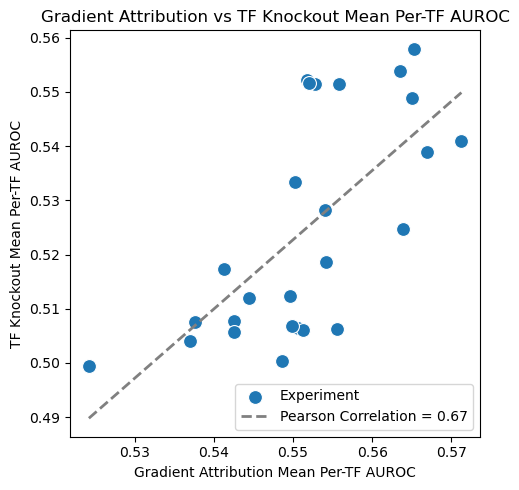

In [45]:
selected_cols = ["Experiment", "Gradient Attribution | Mean | AUROC", "Gradient Attribution | Mean | AUPRC",
                 "TF Knockout | Mean | AUROC", "TF Knockout | Mean | AUPRC", "Gradient Attribution | Mean | Per-TF AUROC",
                 "Gradient Attribution | Mean | Per-TF AUPRC", "TF Knockout | Mean | Per-TF AUROC", "TF Knockout | Mean | Per-TF AUPRC"]

agg_data_df = final_df[selected_cols].copy()
agg_data_df = agg_data_df.rename(columns={
    "Gradient Attribution | Mean | AUROC": "GA_Mean_AUROC",
    "Gradient Attribution | Mean | AUPRC": "GA_Mean_AUPRC",
    "TF Knockout | Mean | AUROC": "TFKO_Mean_AUROC",
    "TF Knockout | Mean | AUPRC": "TFKO_Mean_AUPRC",
    "Gradient Attribution | Mean | Per-TF AUROC": "GA_Mean_Per_TF_AUROC",
    "Gradient Attribution | Mean | Per-TF AUPRC": "GA_Mean_Per_TF_AUPRC",
    "TF Knockout | Mean | Per-TF AUROC": "TFKO_Mean_Per_TF_AUROC",
    "TF Knockout | Mean | Per-TF AUPRC": "TFKO_Mean_Per_TF_AUPRC",
})

# Calculate an overall score for each experiment (mean of all 8 metrics)
agg_data_df["overall_avg"] = (
    agg_data_df[[
        "GA_Mean_AUROC", 
        "GA_Mean_AUPRC", 
        "TFKO_Mean_AUROC", 
        "TFKO_Mean_AUPRC", 
        "GA_Mean_Per_TF_AUROC", 
        "GA_Mean_Per_TF_AUPRC", 
        "TFKO_Mean_Per_TF_AUROC", 
        "TFKO_Mean_Per_TF_AUPRC"
        ]].mean(axis=1)
)
print(agg_data_df.head())

ga_metric = "GA_Mean_Per_TF_AUROC"
tfko_metric = "TFKO_Mean_Per_TF_AUROC"

best_fit_line = np.polyfit(agg_data_df[ga_metric], agg_data_df[tfko_metric], 1)
print(f"Best fit line (TFKO = m*GA + b): m = {best_fit_line[0]:.4f}, b = {best_fit_line[1]:.4f}")
pearson_r = np.corrcoef(agg_data_df[ga_metric], agg_data_df[tfko_metric])[0, 1]
print(f"Pearson correlation coefficient: {pearson_r:.4f}")

plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=agg_data_df,
    x=ga_metric,
    y=tfko_metric,
    s=100,
    label="Experiment"
    )

# Plot the line of best fit
line_range = np.linspace(agg_data_df[ga_metric].min(), agg_data_df[ga_metric].max(), 100)
line = best_fit_line[0] * line_range + best_fit_line[1]
plt.plot(
    line_range, 
    line, 
    color='grey',
    linewidth=2,
    linestyle='--',
    label=f"Pearson Correlation = {pearson_r:.2f}"
    )

if ga_metric == "GA_Mean_AUROC" and tfko_metric == "TFKO_Mean_AUROC":
    plt.title("Gradient Attribution vs TF Knockout Mean AUROC")
    plt.xlabel("Gradient Attribution Mean AUROC")
    plt.ylabel("TF Knockout Mean AUROC")
elif ga_metric == "GA_Mean_Per_TF_AUROC" and tfko_metric == "TFKO_Mean_Per_TF_AUROC":
    plt.title("Gradient Attribution vs TF Knockout Mean Per-TF AUROC")
    plt.xlabel("Gradient Attribution Mean Per-TF AUROC")
    plt.ylabel("TF Knockout Mean Per-TF AUROC")
    
plt.tight_layout()
plt.legend()
plt.show()

                                       Experiment  overall_avg  \
0                                Initial Settings     0.502152   
13             loose_1_pct_filter_50_min_per_cell     0.514865   
4                         strict_10_pct_filtering     0.523683   
10                          slow_decay_long_range     0.524720   
8                               50k_max_peak_dist     0.525068   
23                 two_hops_loose_1_pct_filtering     0.526190   
6                       10k_distance_scale_factor     0.526432   
25    small_model_two_hops_long_range_small_batch     0.526995   
1                              model_d_128_ff_512     0.533760   
5                       40k_distance_scale_factor     0.535733   
7                              150k_max_peak_dist     0.536566   
21             two_hops_10k_distance_scale_factor     0.537252   
14              small_model_loose_1_pct_filtering     0.539768   
20                     two_hops_50k_max_peak_dist     0.541293   
22        

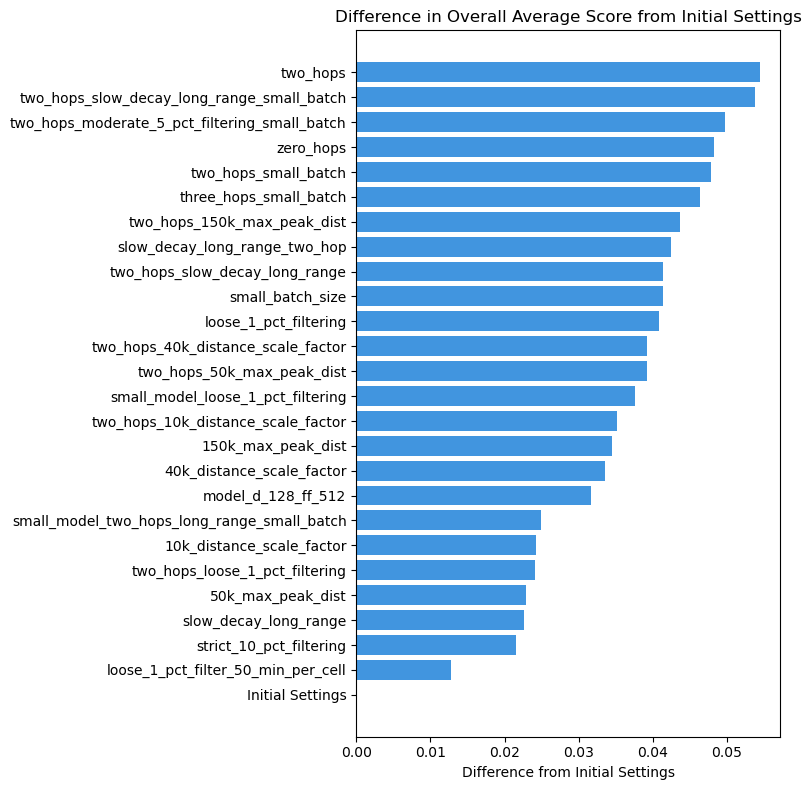

In [46]:
# Experiment by overall average score
agg_data_df = agg_data_df.sort_values(by="overall_avg", ascending=True)

# Difference between the Initial Settings and each experiment
initial_overall_avg = agg_data_df.loc[agg_data_df["Experiment"] == "Initial Settings", "overall_avg"].values[0]
agg_data_df["diff_from_initial"] = agg_data_df["overall_avg"] - initial_overall_avg
print(agg_data_df[["Experiment", "overall_avg", "diff_from_initial"]])

plt.figure(figsize=(8, 8))
plt.barh(agg_data_df["Experiment"], agg_data_df["diff_from_initial"], color='#4195df')
plt.xlabel("Difference from Initial Settings")
plt.title("Difference in Overall Average Score from Initial Settings")
plt.tight_layout()
plt.show()


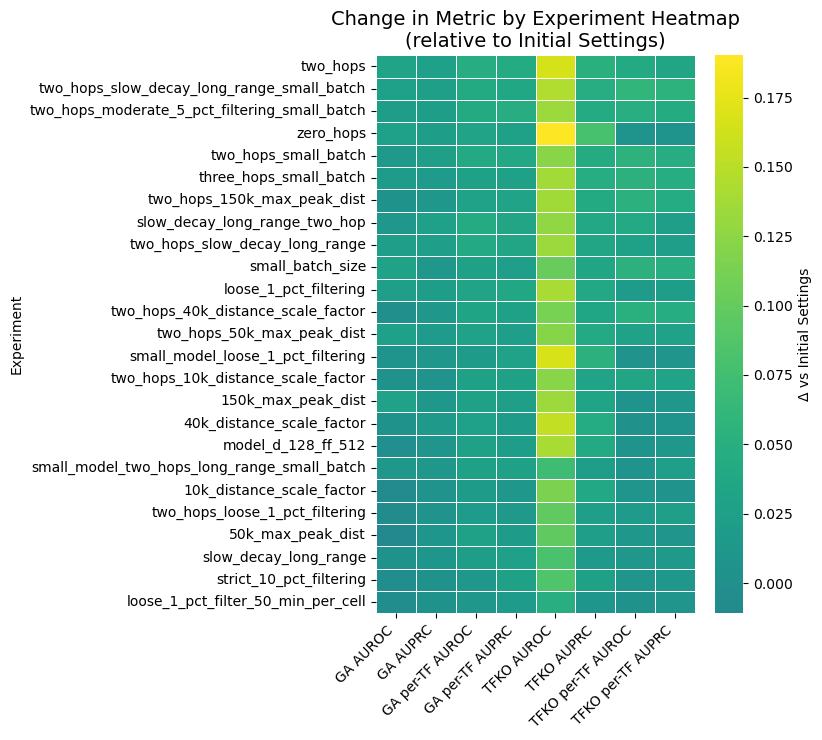

In [47]:
BASELINE = "Initial Settings"

metric_cols = [
    "GA_Mean_AUROC",
    "GA_Mean_AUPRC",
    "GA_Mean_Per_TF_AUROC",
    "GA_Mean_Per_TF_AUPRC",
    "TFKO_Mean_AUROC",
    "TFKO_Mean_AUPRC",
    "TFKO_Mean_Per_TF_AUROC",
    "TFKO_Mean_Per_TF_AUPRC",
]

# Sanity check
missing = set(metric_cols) - set(agg_data_df.columns)
assert not missing, f"Missing columns: {missing}"

# Extract baseline row
baseline_row = agg_data_df.loc[
    agg_data_df["Experiment"] == BASELINE, metric_cols
]

assert len(baseline_row) == 1, "Baseline experiment must appear exactly once"
baseline_row = baseline_row.iloc[0]

# Compute delta per metric
delta_df = agg_data_df.copy()
for c in metric_cols:
    delta_df[c] = delta_df[c] - baseline_row[c]

# Drop baseline itself
delta_df = delta_df[delta_df["Experiment"] != BASELINE]

# Mean delta across all metrics (for sorting)
delta_df["mean_delta"] = delta_df[metric_cols].mean(axis=1)

# Sort experiments by overall improvement
delta_df = delta_df.sort_values("mean_delta", ascending=False)

# Pretty metric labels for plotting
pretty_cols = {
    "GA_Mean_AUROC": "GA AUROC",
    "GA_Mean_AUPRC": "GA AUPRC",
    "GA_Mean_Per_TF_AUROC": "GA per-TF AUROC",
    "GA_Mean_Per_TF_AUPRC": "GA per-TF AUPRC",
    "TFKO_Mean_AUROC": "TFKO AUROC",
    "TFKO_Mean_AUPRC": "TFKO AUPRC",
    "TFKO_Mean_Per_TF_AUROC": "TFKO per-TF AUROC",
    "TFKO_Mean_Per_TF_AUPRC": "TFKO per-TF AUPRC",
}

heat = (
    delta_df
    .set_index("Experiment")[metric_cols]
    .rename(columns=pretty_cols)
)

plt.figure(figsize=(8, max(4, 0.30 * heat.shape[0])))
sns.heatmap(
    heat,
    center=0,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    annot=False,
    cbar_kws={"label": "Δ vs Initial Settings"},
)

plt.title("Change in Metric by Experiment Heatmap\n(relative to Initial Settings)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


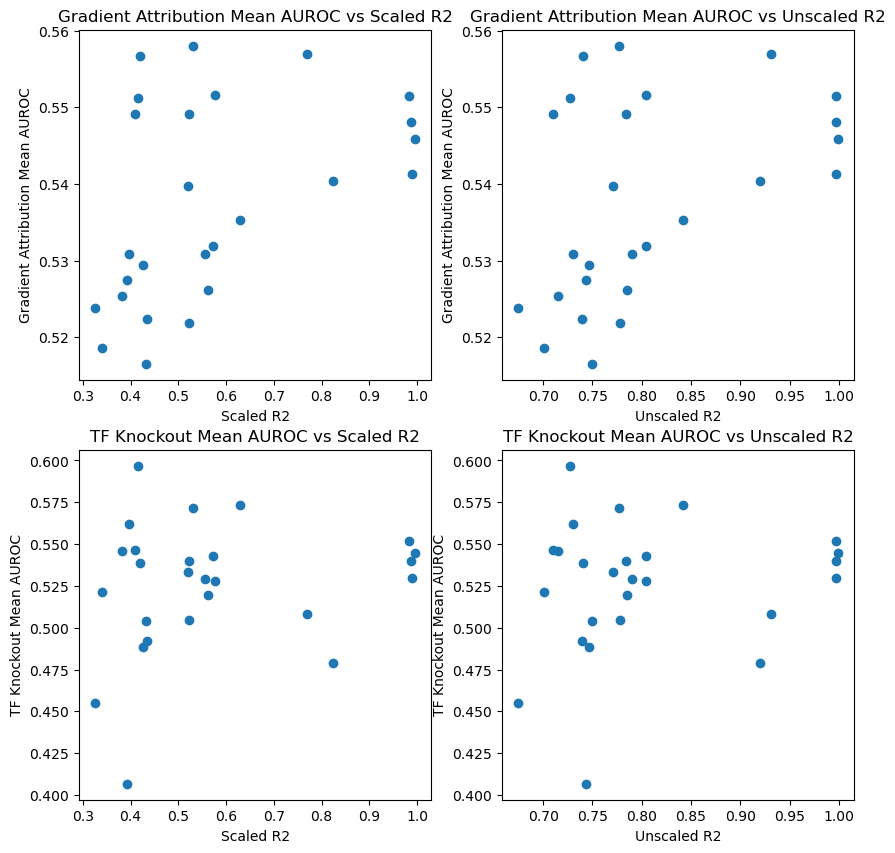

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax[0,0].set_title("Gradient Attribution Mean AUROC vs Scaled R2")
ax[0,0].scatter(final_df["scaled_r2"], final_df["Gradient Attribution | Mean | AUROC"])
ax[0,0].set_ylabel("Gradient Attribution Mean AUROC")
ax[0,0].set_xlabel("Scaled R2")

ax[0,1].set_title("Gradient Attribution Mean AUROC vs Unscaled R2")
ax[0,1].scatter(final_df["unscaled_r2"], final_df["Gradient Attribution | Mean | AUROC"])
ax[0,1].set_ylabel("Gradient Attribution Mean AUROC")
ax[0,1].set_xlabel("Unscaled R2")

ax[1,0].set_title("TF Knockout Mean AUROC vs Scaled R2")
ax[1,0].scatter(final_df["scaled_r2"], final_df["TF Knockout | Mean | AUROC"])
ax[1,0].set_ylabel("TF Knockout Mean AUROC")
ax[1,0].set_xlabel("Scaled R2")

ax[1,1].set_title("TF Knockout Mean AUROC vs Unscaled R2")
ax[1,1].scatter(final_df["unscaled_r2"], final_df["TF Knockout | Mean | AUROC"])
ax[1,1].set_ylabel("TF Knockout Mean AUROC")
ax[1,1].set_xlabel("Unscaled R2")


plt.show()

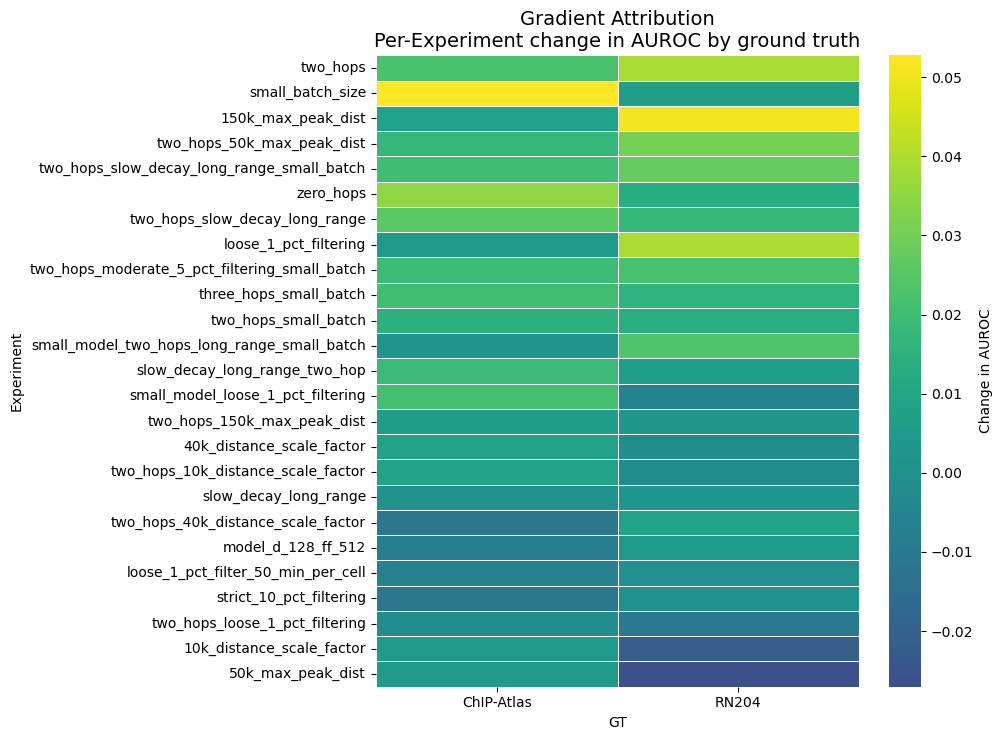

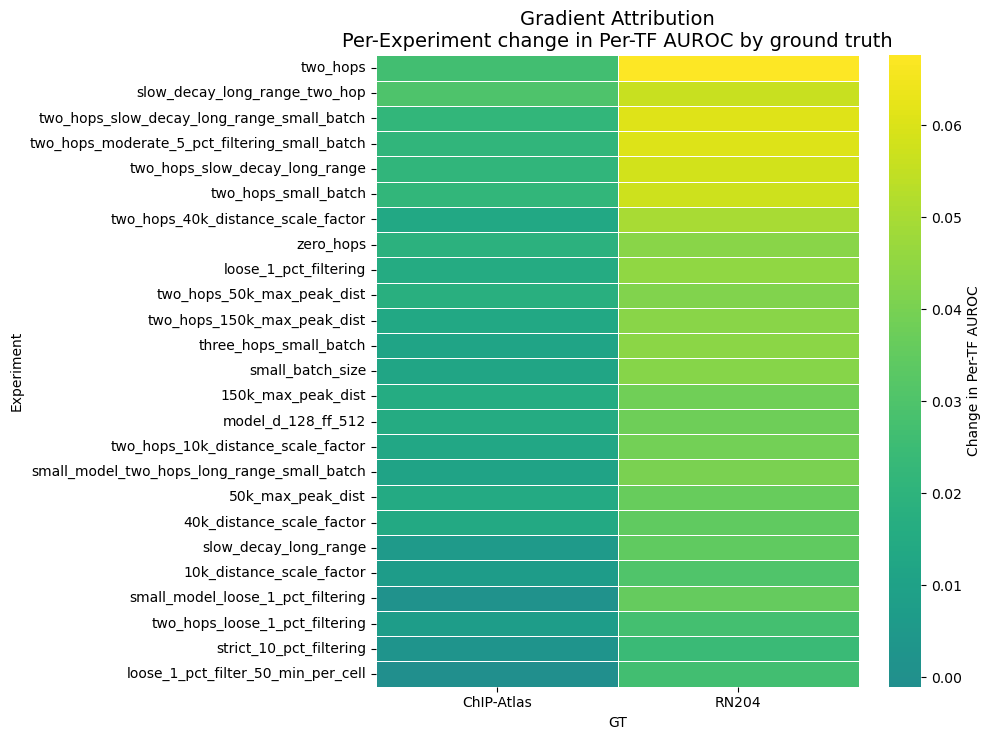

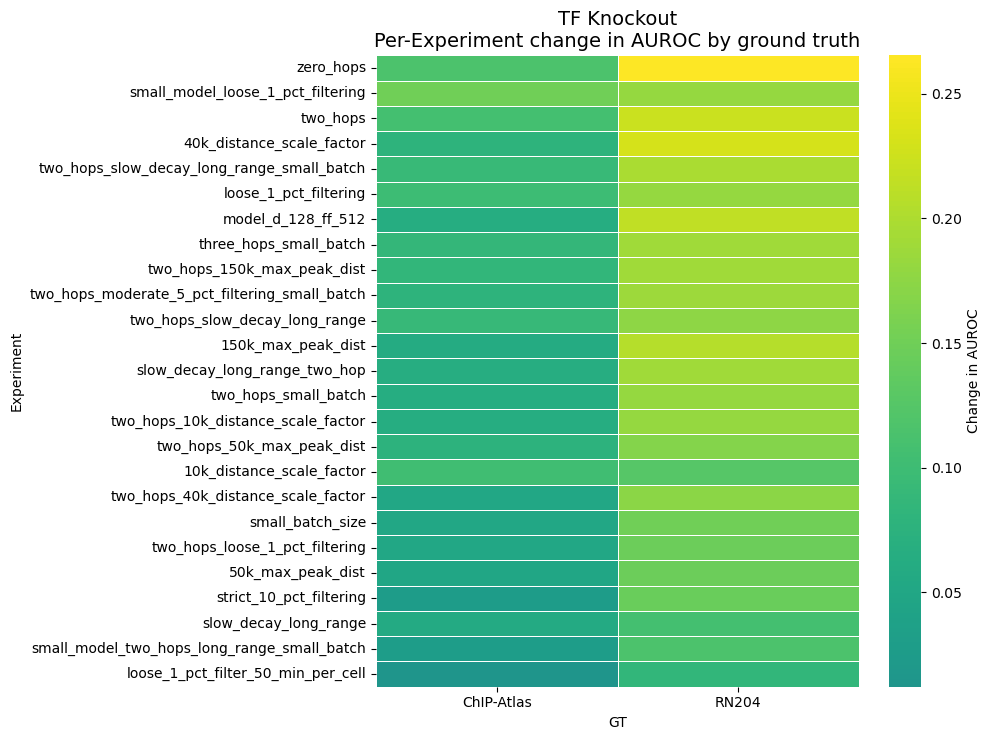

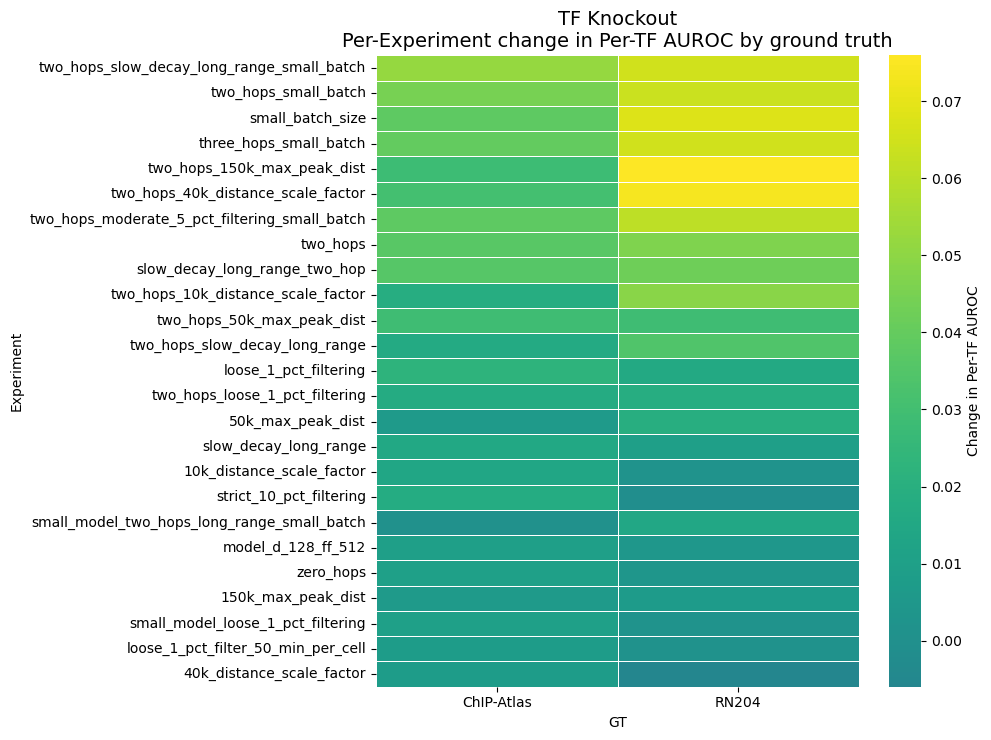

In [49]:
df = final_df.copy()

# Baseline experiment
BASELINE = "Initial Settings"

GTs = GT_ORDER
METHODS = ["Gradient Attribution", "TF Knockout"]

def melt_gt_metrics(df, metric="Per-TF AUROC"):
    """
    Returns tidy df with:
    Experiment | Method | GT | Value
    """
    rows = []
    for _, r in df.iterrows():
        exp = r["Experiment"]
        for method in METHODS:
            for gt in GTs:
                col = f"{method} | {gt} | {metric}"
                if col in df.columns:
                    rows.append({
                        "Experiment": exp,
                        "Method": method,
                        "Metric": metric,
                        "GT": gt,
                        "Value": r[col]
                    })
    return pd.DataFrame(rows)

def compute_gt_deltas(long_df):
    baseline = (
        long_df[long_df["Experiment"] == BASELINE]
        .set_index(["Method", "GT", "Metric"])["Value"]
    )

    long_df = long_df.copy()
    long_df["Delta"] = long_df.apply(
        lambda r: r["Value"] - baseline.loc[(r["Method"], r["GT"])],
        axis=1
    )
    return long_df

def plot_gt_delta_heatmap(per_tf_delta, method, selected_metric, sort_by="mean"):
    sub = per_tf_delta[
        (per_tf_delta["Method"] == method) &
        (per_tf_delta["Experiment"] != BASELINE) &
        (per_tf_delta["Metric"] == selected_metric)
    ]

    mat = sub.pivot_table(
        index="Experiment",
        columns="GT",
        values="Delta",
        aggfunc="mean"
    )

    if sort_by == "mean":
        mat = mat.loc[mat.mean(axis=1).sort_values(ascending=False).index]

    plt.figure(figsize=(10, max(6, 0.30 * len(mat))))
    sns.heatmap(
        mat,
        center=0,
        cmap="viridis",
        linewidths=0.5,
        cbar_kws={"label": f"Change in {selected_metric}"}
    )
    plt.title(f"{method}\nPer-Experiment change in {selected_metric} by ground truth", fontsize=14)
    plt.tight_layout()
    plt.show()

# "AUROC" for mean AUROC, "Per-TF AUROC" for mean Per-TF AUROC
# Mean AUROC for plotting
mean_melted_df = melt_gt_metrics(df, metric="AUROC")
mean_gt_delta = compute_gt_deltas(mean_melted_df)
mean_ranked = (
    mean_gt_delta[mean_gt_delta["Experiment"] != BASELINE]
    .groupby(["Method", "GT", "Metric", "Experiment"])["Delta"]
    .mean()
    .reset_index()
    .sort_values(["Method", "GT", "Delta"], ascending=[True, True, False])
)

# Per-TF AUROC for plotting
per_tf_melted_df = melt_gt_metrics(df, metric="Per-TF AUROC")
per_tf_gt_delta = compute_gt_deltas(per_tf_melted_df)
per_tf_ranked = (
    per_tf_gt_delta[per_tf_gt_delta["Experiment"] != BASELINE]
    .groupby(["Method", "GT", "Metric", "Experiment"])["Delta"]
    .mean()
    .reset_index()
    .sort_values(["Method", "GT", "Delta"], ascending=[True, True, False])
)


plot_gt_delta_heatmap(mean_ranked, "Gradient Attribution", "AUROC")
plot_gt_delta_heatmap(per_tf_ranked, "Gradient Attribution", "Per-TF AUROC")
plot_gt_delta_heatmap(mean_ranked, "TF Knockout", "AUROC")
plot_gt_delta_heatmap(per_tf_ranked, "TF Knockout", "Per-TF AUROC")

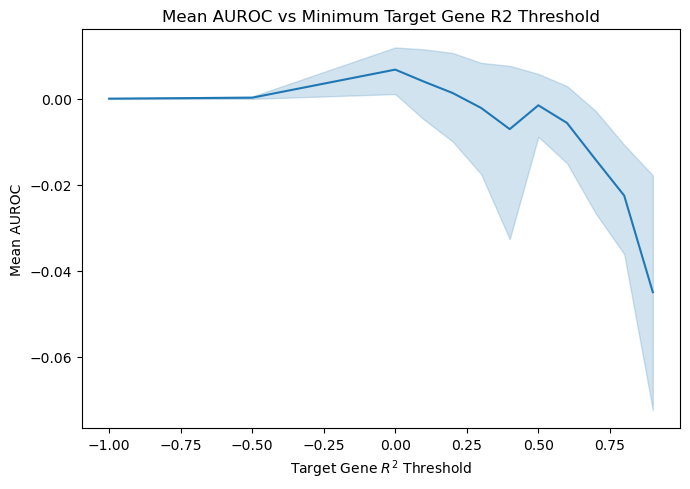

In [42]:
all_experiments = []
for experiment_name, experiment_dir in experiment_dict.items():
    if "auroc_by_tg_r2_threshold.csv" in os.listdir(experiment_dir):
        auroc_by_r2 = pd.read_csv(experiment_dir / "auroc_by_tg_r2_threshold.csv", header=0)
        
        auroc_by_r2["Experiment"] = experiment_name
        all_experiments.append(auroc_by_r2)
        
    else:
        print("  auroc_by_tg_r2_threshold.csv not found.")
        
total_threshold_by_tg_r2_df = pd.concat(all_experiments, axis=0, ignore_index=True)

cols = ["Experiment", "frac_edges_kept", "min_tg_r2", "baseline_macro", "baseline_micro", "macro_auroc", "micro_auroc"]

final_df = total_threshold_by_tg_r2_df[cols].copy()
final_df["standardized_macro_auroc"] = (final_df["macro_auroc"] - final_df["baseline_macro"]) / (1 - final_df["baseline_macro"])
final_df["standardized_micro_auroc"] = (final_df["micro_auroc"] - final_df["baseline_micro"]) / (1 - final_df["baseline_micro"])

plt.figure(figsize=(7,5))
# Density plot
sns.lineplot(
    data=final_df,
    x="min_tg_r2",
    y="standardized_macro_auroc",
    legend=False
    )

plt.title("Mean AUROC vs Minimum Target Gene R2 Threshold")
plt.xlabel(f"Target Gene $R^{2}$ Threshold")
plt.ylabel("Mean AUROC")
plt.tight_layout()
plt.show()

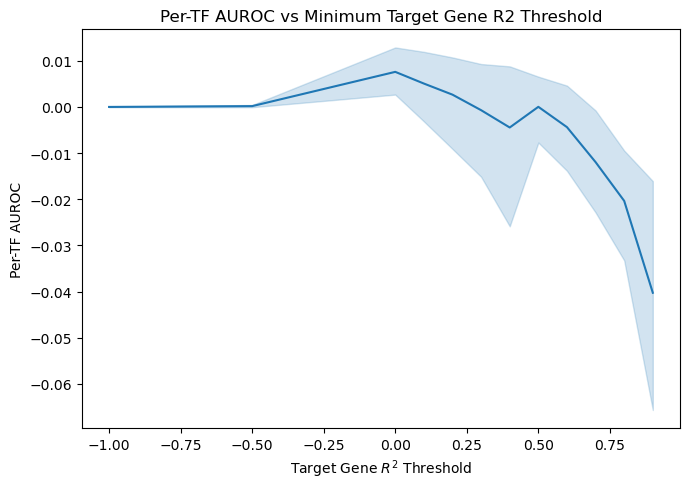

In [43]:
plt.figure(figsize=(7,5))
# Density plot
sns.lineplot(
    data=final_df,
    x="min_tg_r2",
    y="standardized_micro_auroc",
    legend=False
    )

plt.title("Per-TF AUROC vs Minimum Target Gene R2 Threshold")
plt.xlabel(f"Target Gene $R^{2}$ Threshold")
plt.ylabel("Per-TF AUROC")
plt.tight_layout()
plt.show()

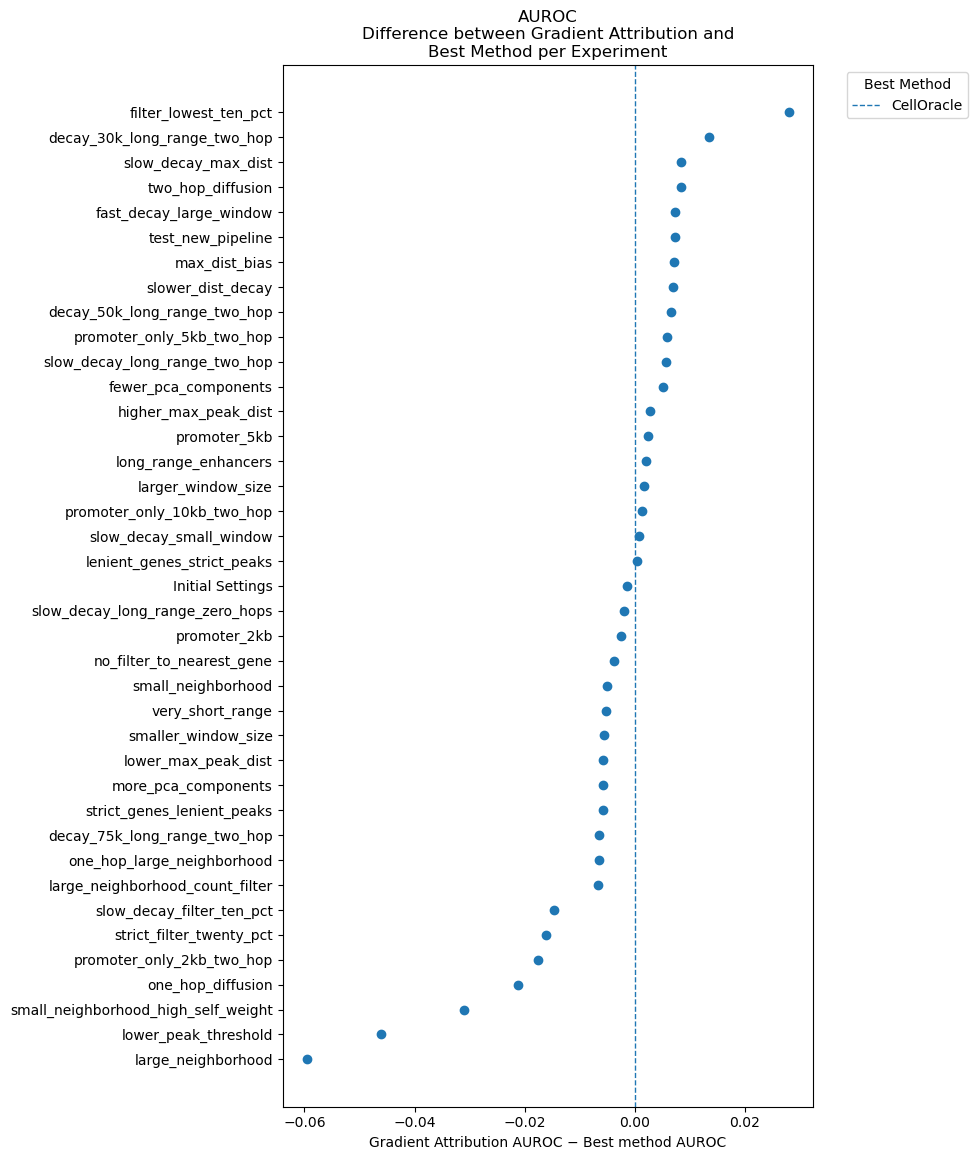

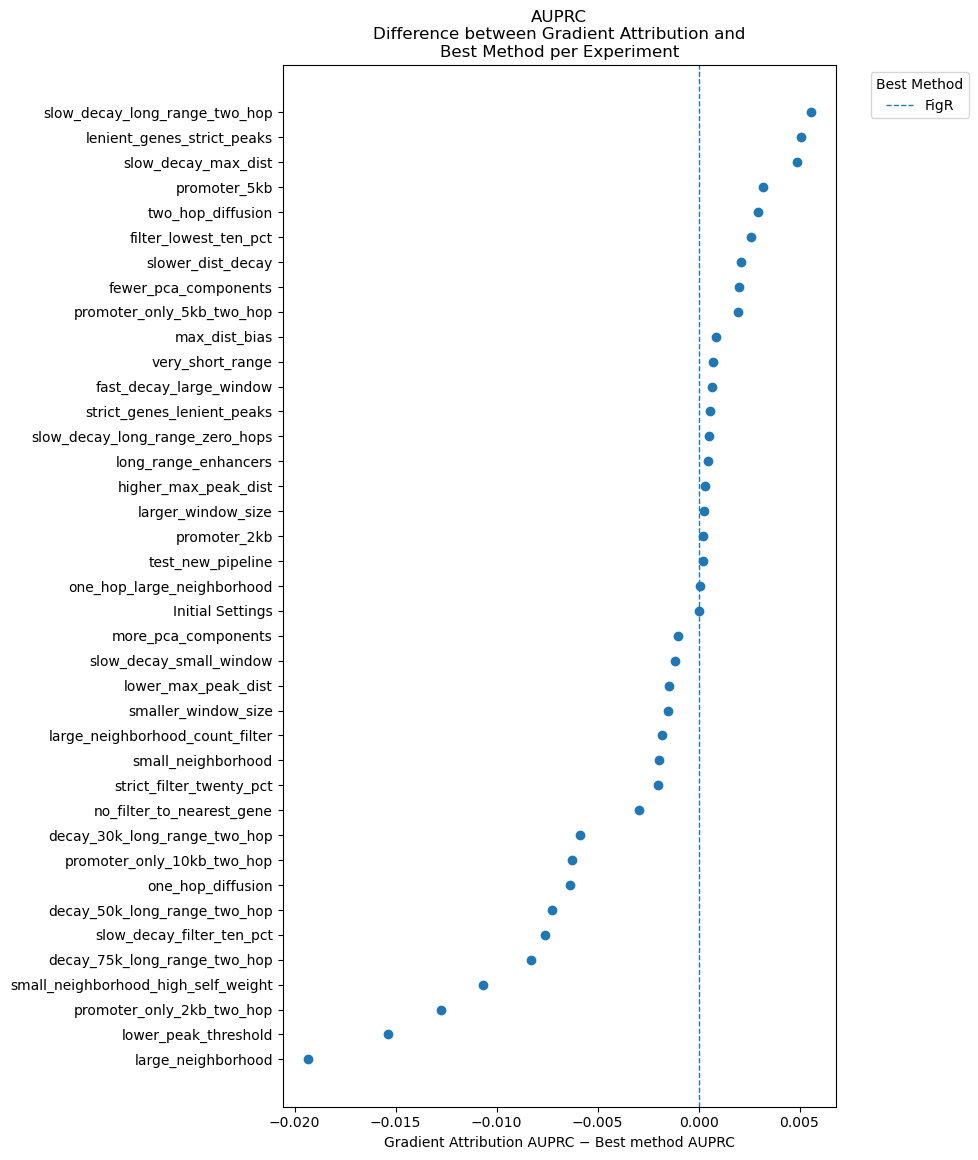

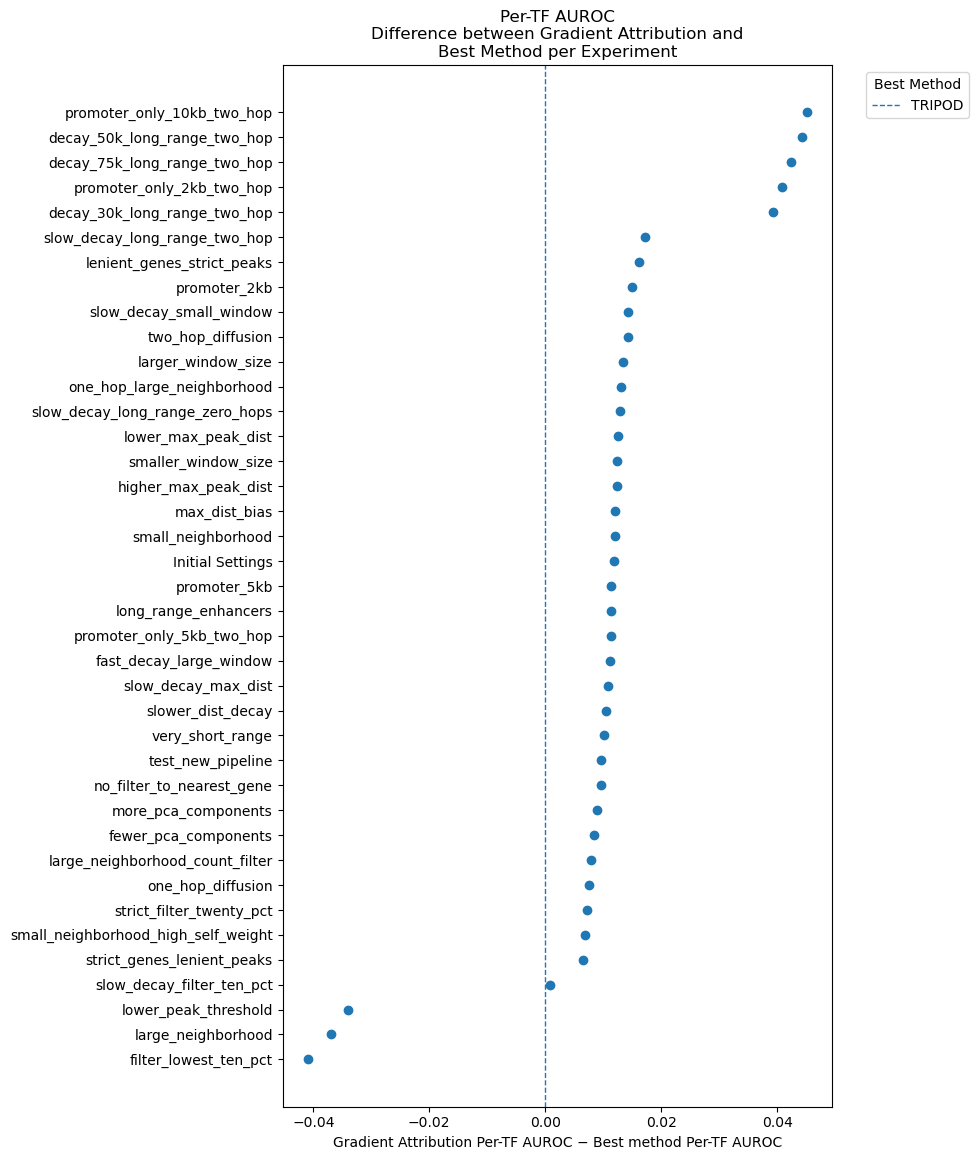

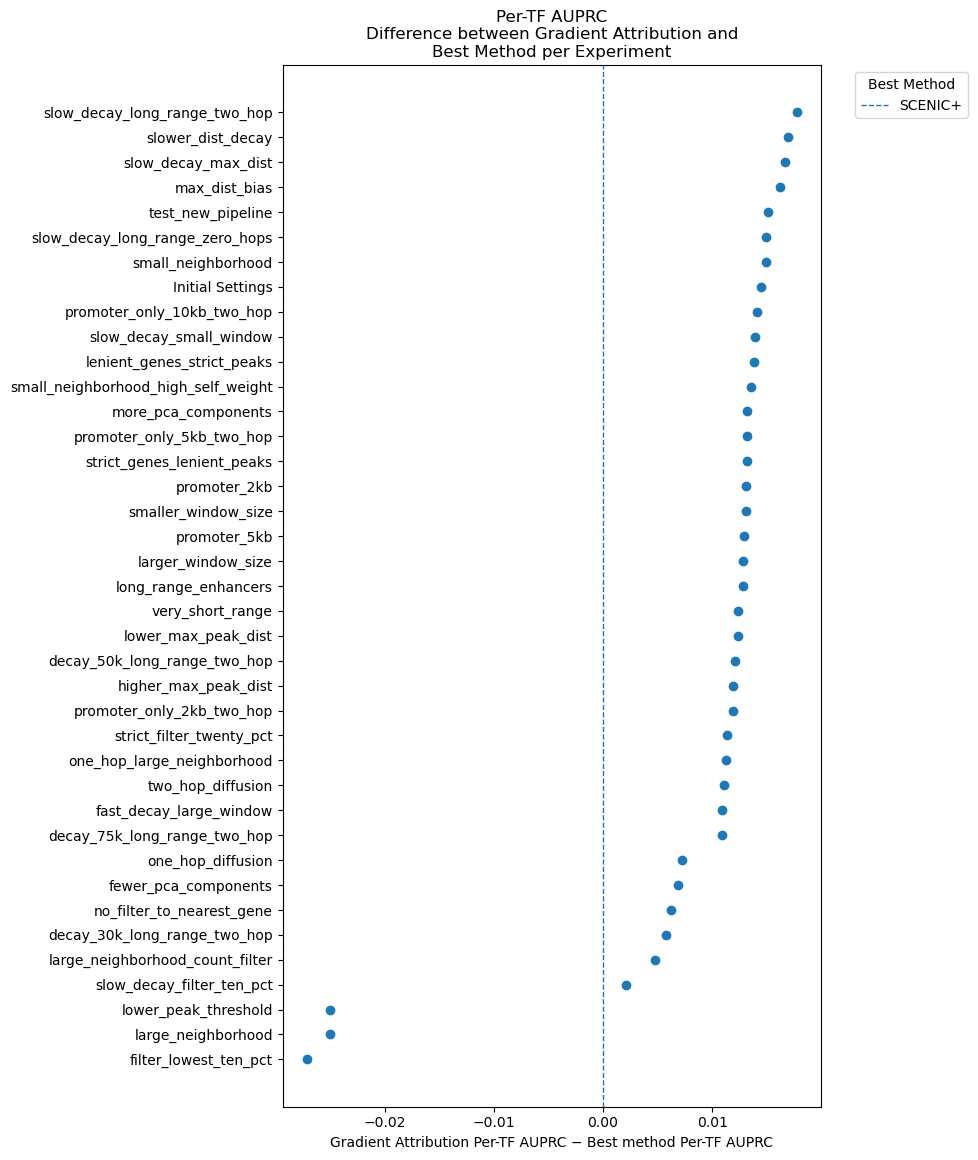

In [117]:
METRIC_TO_COMPARE = "Gradient Attribution"  # "Gradient Attribution" or "TF Knockout"

if METRIC_TO_COMPARE == "Gradient Attribution":
    EXCLUDE = {"TF Knockout"}
elif METRIC_TO_COMPARE == "TF Knockout":
    EXCLUDE = {"Gradient Attribution"}
else:
    print("Choose either 'Gradient Attribution' or 'TF Knockout' for METRIC_TO_COMPARE")

metric_by_method = []
per_tf_metric_by_method = []
for experiment_name, experiment_dir in experiment_dict.items():
    if "method_ranking_by_auroc_pooled.csv" in os.listdir(experiment_dir):
        auroc_per_method = pd.read_csv(experiment_dir / "method_ranking_by_auroc_pooled.csv", header=0, index_col=None)
        per_tf_metrics = pd.read_csv(experiment_dir / "method_ranking_by_per_tf_auroc.csv", index_col=None)

        
        auroc_per_method["Experiment"] = experiment_name
        per_tf_metrics["Experiment"] = experiment_name
        
        metric_by_method.append(auroc_per_method)
        per_tf_metric_by_method.append(per_tf_metrics)
        
        
    else:
        print("  method_ranking_by_auroc_pooled.csv not found.")
        
total_metric_by_method = pd.concat(metric_by_method, axis=0, ignore_index=True)
total_per_tf_metric_by_method = pd.concat(per_tf_metric_by_method, axis=0, ignore_index=True).rename(columns={"method":"name"})

auroc_by_method_pivot = total_metric_by_method.pivot(index="Experiment", columns="name", values="mean_auroc")
auprc_by_method_pivot = total_metric_by_method.pivot(index="Experiment", columns="name", values="mean_auprc")
per_tf_auroc_by_method_pivot = total_per_tf_metric_by_method.pivot_table(index="Experiment", columns="name", values="mean_auroc")
per_tf_auprc_by_method_pivot = total_per_tf_metric_by_method.pivot_table(index="Experiment", columns="name", values="mean_auprc")

def plot_difference_vs_best(metric_by_method_pivot, metric_name, METRIC_TO_COMPARE, EXCLUDE):
    exclude_all = set(EXCLUDE) | {METRIC_TO_COMPARE}
    cols = [c for c in metric_by_method_pivot.columns if c not in exclude_all]
    best = metric_by_method_pivot[cols].max(axis=1)
    gap = metric_by_method_pivot[METRIC_TO_COMPARE] - best
    gap = gap.sort_values()  # best experiments (smallest gap) on top
    best_method_name = metric_by_method_pivot[cols].idxmax(axis=1).loc[gap.index].iloc[0]


    fig, ax = plt.subplots(figsize=(10, max(4, 0.3*len(gap))))
    
    ax.scatter(gap.values, np.arange(len(gap)))
    
    
    ax.axvline(0, linestyle="--", linewidth=1, label=best_method_name)
    ax.set_yticks(np.arange(len(gap)))
    ax.set_yticklabels(gap.index)
    ax.set_xlabel(f"{METRIC_TO_COMPARE} {metric_name} − Best method {metric_name}")
    ax.set_title(f"{metric_name}\nDifference between {METRIC_TO_COMPARE} and\nBest Method per Experiment")
    plt.legend(title="Best Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    plt.show()

plot_difference_vs_best(auroc_by_method_pivot, "AUROC", METRIC_TO_COMPARE, EXCLUDE)
plot_difference_vs_best(auprc_by_method_pivot, "AUPRC", METRIC_TO_COMPARE, EXCLUDE)
plot_difference_vs_best(per_tf_auroc_by_method_pivot, "Per-TF AUROC", METRIC_TO_COMPARE, EXCLUDE)
plot_difference_vs_best(per_tf_auprc_by_method_pivot, "Per-TF AUPRC", METRIC_TO_COMPARE, EXCLUDE)


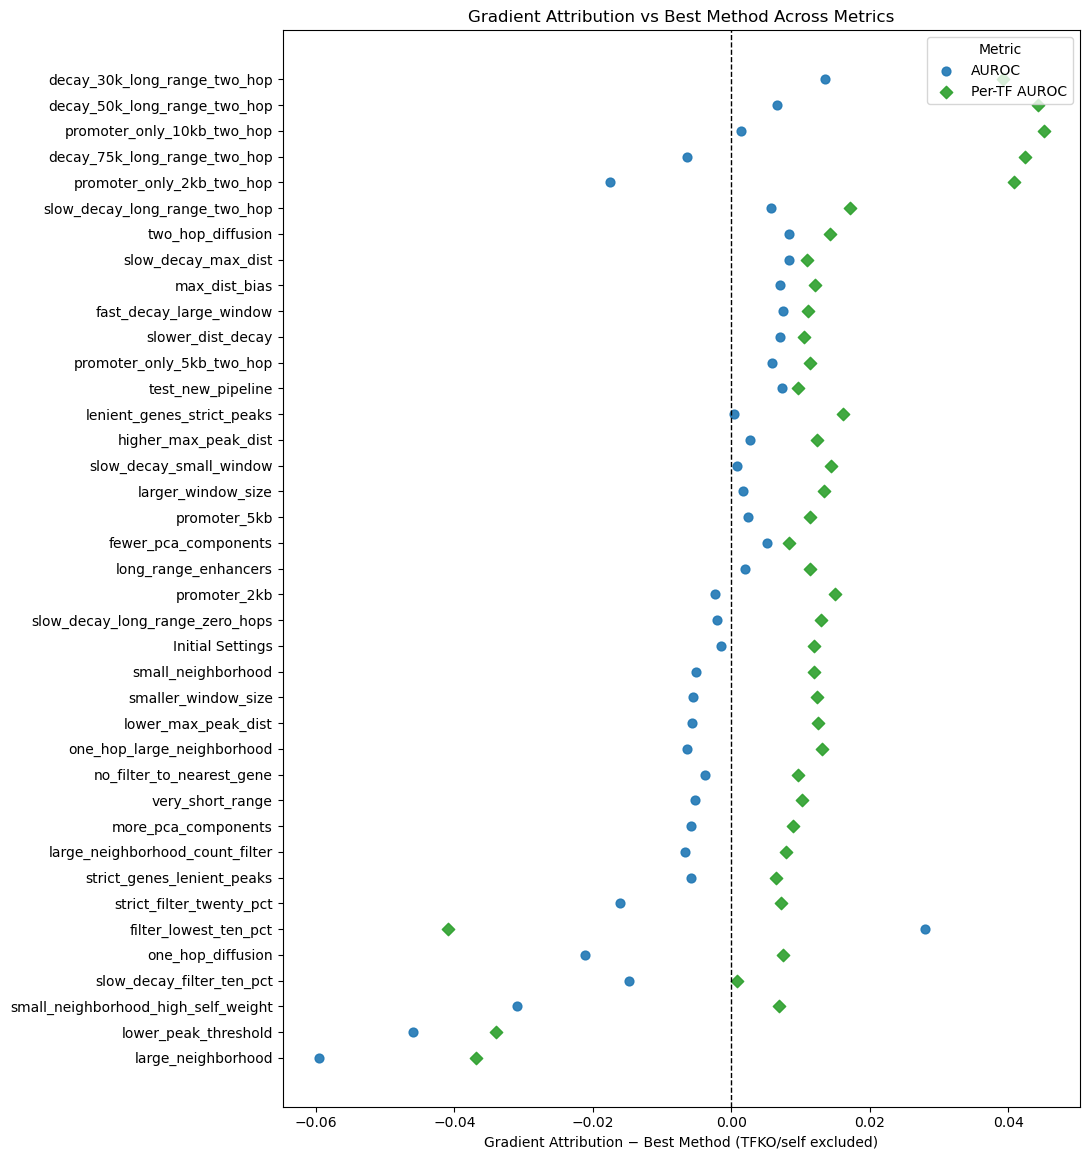

In [123]:
def compute_gap(metric_by_method_pivot, METRIC_TO_COMPARE, EXCLUDE):
    exclude_all = set(EXCLUDE) | {METRIC_TO_COMPARE}
    cols = [c for c in metric_by_method_pivot.columns if c not in exclude_all]

    best = metric_by_method_pivot[cols].max(axis=1)
    gap = metric_by_method_pivot[METRIC_TO_COMPARE] - best
    return gap

gap_auroc        = compute_gap(auroc_by_method_pivot, METRIC_TO_COMPARE, EXCLUDE)
gap_auprc        = compute_gap(auprc_by_method_pivot, METRIC_TO_COMPARE, EXCLUDE)
gap_ptf_auroc    = compute_gap(per_tf_auroc_by_method_pivot, METRIC_TO_COMPARE, EXCLUDE)
gap_ptf_auprc    = compute_gap(per_tf_auprc_by_method_pivot, METRIC_TO_COMPARE, EXCLUDE)

gap_df = pd.DataFrame({
    "AUROC": gap_auroc,
    # "AUPRC": gap_auprc,
    "Per-TF AUROC": gap_ptf_auroc,
    # "Per-TF AUPRC": gap_ptf_auprc,
})

experiment_order = (
    gap_df
          .sum(axis=1)
          .sort_values(ascending=True)
          .index
)

gap_df = gap_df.loc[experiment_order]

fig, ax = plt.subplots(figsize=(11, max(4, 0.3 * len(gap_df))))

y = np.arange(len(gap_df))

colors = {
    "AUROC": "tab:blue",
    # "AUPRC": "tab:orange",
    "Per-TF AUROC": "tab:green",
    # "Per-TF AUPRC": "tab:red",
}

markers = {
    "AUROC": "o",
    # "AUPRC": "s",
    "Per-TF AUROC": "D",
    # "Per-TF AUPRC": "^",
}

for metric in gap_df.columns:
    ax.scatter(
        gap_df[metric].values,
        y,
        label=metric,
        color=colors[metric],
        marker=markers[metric],
        s=40,
        alpha=0.9,
    )

# Reference line: ties best method
ax.axvline(0, linestyle="--", color="black", linewidth=1)

ax.set_yticks(y)
ax.set_yticklabels(gap_df.index)
ax.set_xlabel(f"{METRIC_TO_COMPARE} − Best Method (TFKO/self excluded)")
ax.set_title(f"{METRIC_TO_COMPARE} vs Best Method Across Metrics")

ax.legend(title="Metric", loc="upper right")
fig.tight_layout()
plt.show()

